## Task 1 - STREAM Benchmark in Python to Measure the Memory Bandwidth

The [STREAM benchmark](https://www.cs.virginia.edu/stream/) is a very famous benchmark for measuring the sustainable memory bandwidth of a system.

It will do so for **four different operations** on very large arrays (called x, y and z here):

| Name     | Operation                |
|:---------|:-------------------------|
| 1. COPY  | `x(i) = y(i)`            |
| 2. ADD   | `x(i) = y(i) + z(i)`     |
| 3. SCALE | `x(i) = a * y(i)`        |
| 5. TRIAD | `x(i) = y(i) + a * z(i)` |


In this assignment, we are going to test standard Python lists, as well as arrays for the `array` module.
Because of memory fragmentation and support (or not) for vectorization, using different Python arrays will impact the performance.

### Arrays initialization
First, we need to create and fill with data the arrays we will be using for our benchmark

In [1]:
import array as arr

def get_test_arrays(array_size):
    # Initializing Python lists
    a1 = [1.0 for i in range(array_size)]
    b1 = [2.0 for i in range(array_size)]
    c1 = [0.0 for i in range(array_size)]

    # Initializing arrays
    a2 = arr.array('d', a1)
    b2 = arr.array('d', b1)
    c2 = arr.array('d', c1)
    
    scalar = 2.0
    
    return [a1, b1, c1, a2, b2, c2, scalar]



### Timing the operations

In [2]:
from time import time

# Function for running the benchmark
def run_STREAM(a, b, c, scalar, array_size):
    
    times = [0 for i in range(4)]
    
    # Repeat each of these 100 times and take average
    # COPY
    times[0] = time()
    for j in range(len(a)):
        c[j] = a[j]
    times[0] = time() - times[0]
    
    # ADD
    times[2] = time()
    for j in range(len(a)):
         c[j] = a[j]+b[j]
    times[2] = time() - times[2]
    
    # SCALE
    times[1] = time()
    for j in range(len(a)):
         b[j] = scalar*c[j]
    times[1] = time() - times[1]

    # TRIAD
    times[3] = time()
    for j in range(len(a)):
        a[j] = b[j]+scalar*c[j]
    times[3] = time() - times[3]
    
    return times

In [3]:
import statistics

# Function for running the benchmark
def run_STREAM_average(a, b, c, scalar, array_size, n):
    
    times = [[] for i in range(4)]
    
    for i in range(n):
        # COPY
        times[0].append(time())
        for j in range(len(a)):
            c[j] = a[j]
        times[0][-1] = time() - times[0][-1]

        # ADD
        times[2].append(time())
        for j in range(len(a)):
             c[j] = a[j]+b[j]
        times[2][-1] = time() - times[2][-1]

        # SCALE
        times[1].append(time())
        for j in range(len(a)):
             b[j] = scalar*c[j]
        times[1][-1] = time() - times[1][-1]

        # TRIAD
        times[3].append(time())
        for j in range(len(a)):
            a[j] = b[j]+scalar*c[j]
        times[3][-1] = time() - times[3][-1]
        
    for t in range(4):
        times[t] = statistics.mean(times[t])
    
    return times

### Computing the memory bandwitdth
Looking at the example below, we can see that regardless of if we use list or arrays, the elements take the same space in memory, which in this case seems to be 8 bytes. This is because both lists and arrays store references to their elements, which are 64 bits addresses. Arrays can't just store elements next to one another in memory because for example a double could need more than 8 bytes to be stored, so everything would get shifted.

In [4]:
import sys 
import array 

if __name__ == "__main__": 
    array_a = array.array('d',[])
    array_b = array.array('d',[0, 1475837548574837958749274973498, 12, 23]) 
    
    print("Size of empty array: " + str(sys.getsizeof(array_a)))
    print("Size of array with 4 elements: " + str(sys.getsizeof(array_b)))
    print("Size of the 4 elements themselves: " + str(sys.getsizeof(array_b)-sys.getsizeof(array_a)))
    print("")
    
    list_a = [] 
    list_b = [0, 1475837548574837958749274973498, 12, 23] 
    
    print("Size of empty list: " + str(sys.getsizeof(list_a)))
    print("Size of list with 4 elements: " + str(sys.getsizeof(list_b)))
    print("Size of the 4 elements themselves: " + str(sys.getsizeof(list_b)-sys.getsizeof(list_a)))

Size of empty array: 80
Size of array with 4 elements: 112
Size of the 4 elements themselves: 32

Size of empty list: 56
Size of list with 4 elements: 88
Size of the 4 elements themselves: 32


In [5]:
def get_memory_bandwidths(array_size, times_list, times_array):
    def get_estimated_array_size(a):
        return 8 * array_size

    def get_ops_data_moved(a):
        size = sys.getsizeof(a)
        return (2 * size, 3 * size, 2 * size, 3 * size)

    def get_bandwidths(ops_data_moved, times):
        bandwidths = []
        for i in range(4):
            bandwidths.append(ops_data_moved[i] / times[i])

        return bandwidths

    data_moved_list = get_ops_data_moved(a1)
    data_moved_array = get_ops_data_moved(a2)

    return (get_bandwidths(data_moved_list, times_list), get_bandwidths(data_moved_array, times_array))

### Putting everything together

In [6]:
array_sizes_to_test = [10 ** i for i in range(1,7)] + [10 ** 6 * i for i in range(2, 6)]

results_list = []
results_array = []

counter = 1
test_number = len(array_sizes_to_test)

for size in array_sizes_to_test:
    print("Running test " + str(counter) + " out of " + str(test_number))
    a1, b1, c1, a2, b2, c2, scalar = get_test_arrays(size)
    times_list = run_STREAM_average(a1, b1, c1, scalar, size, 100)
    times_array = run_STREAM_average(a2, b2, c2, scalar, size, 100)
    
    memory_bandwidths_list, memory_bandwidths_array = get_memory_bandwidths(size, times_list, times_array)
    
    results_list.append(memory_bandwidths_list)
    results_array.append(memory_bandwidths_array)
    counter += 1
    
print("Done")

Running test 1 out of 10
Running test 2 out of 10
Running test 3 out of 10
Running test 4 out of 10
Running test 5 out of 10
Running test 6 out of 10
Running test 7 out of 10
Running test 8 out of 10
Running test 9 out of 10
Running test 10 out of 10
Done


### Plotting the results

In [7]:
import matplotlib.pyplot as plt
import numpy as np


def get_points_xy(operation_id, array_sizes, results):
    points = []

    for i in range(len(array_sizes)):
        points.append([array_sizes[i], results[i][operation_id]])
    
        
    data = np.array([points])
    x, y = data.T
    
    x = np.log10(x)
    
    return [x, y]
    
    
def plot_operation(operation_id, results, color, label):
    x, y = get_points_xy(operation_id, array_sizes_to_test, results)
    plt.scatter(x, y, color=color, marker='o', label=label)


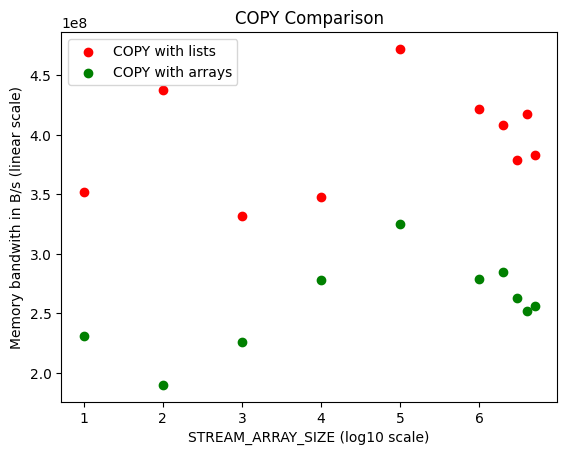

In [8]:
plot_operation(0, results_list, 'red', 'copy list')
plot_operation(0, results_array, 'green', 'copy array')
plt.legend(['COPY with lists','COPY with arrays']) 
plt.title("COPY Comparison")
plt.xlabel('STREAM_ARRAY_SIZE (log10 scale)')
plt.ylabel('Memory bandwith in B/s (linear scale)')
plt.show()

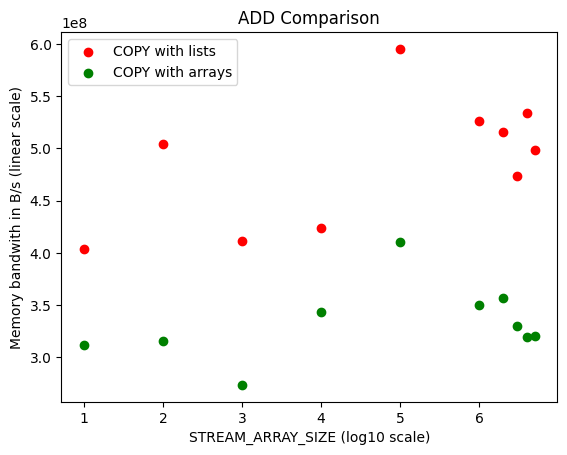

In [9]:
plot_operation(1, results_list, 'red', 'add list')
plot_operation(1, results_array, 'green', 'add array')
plt.legend(['COPY with lists','COPY with arrays']) 
plt.title("ADD Comparison")
plt.xlabel('STREAM_ARRAY_SIZE (log10 scale)')
plt.ylabel('Memory bandwith in B/s (linear scale)')
plt.show()

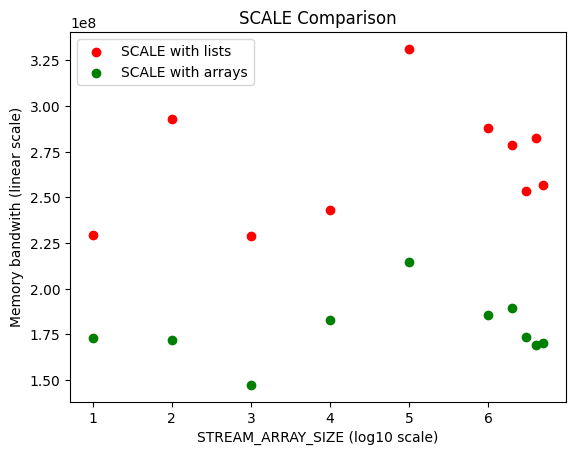

In [10]:
plot_operation(2, results_list, 'red', 'add list')
plot_operation(2, results_array, 'green', 'add array')
plt.legend(['SCALE with lists','SCALE with arrays']) 
plt.title("SCALE Comparison")
plt.xlabel('STREAM_ARRAY_SIZE (log10 scale)')
plt.ylabel('Memory bandwith (linear scale)')
plt.show()

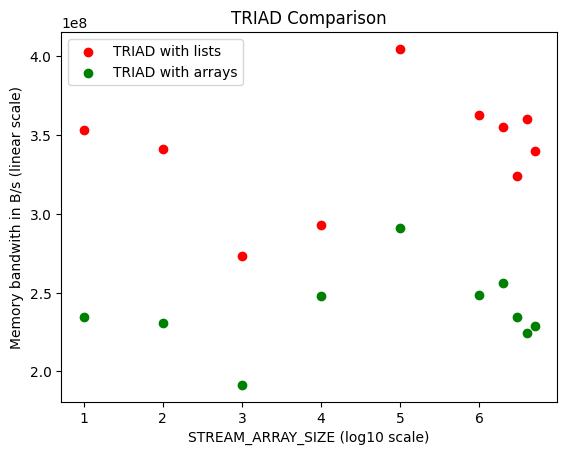

In [11]:
plot_operation(3, results_list, 'red', 'add list')
plot_operation(3, results_array, 'green', 'add array')
plt.legend(['TRIAD with lists','TRIAD with arrays']) 
plt.title("TRIAD Comparison")
plt.xlabel('STREAM_ARRAY_SIZE (log10 scale)')
plt.ylabel('Memory bandwith in B/s (linear scale)')
plt.show()

### How does the bandwidth vary when increasing the STREAM_ARRAY_SIZE, and why?
We can see a similar pattern in the 4 plots above. Everytime, we have a linear increase until 10^2, and then the bandwidth goes down as the array size increases. The bandwidth probably gets constant when it reaches it maximum sustainable value, and is lower before because the amount of data is really small. Then it goes down because more and more data has to be fetched from memory, as the cache starts to fill up.
Note that we ran each experiment 100 times, so that we average out the possible single event that could make a measurement wrong, like an OS context switch or core migration which we have no control on. As a result, we have much cleaner graphs.

### How do the different implementation bandwidths compare to each other? 
We can see that in the 4 cases tested here, the arrays perform much better than the Python lists, with a speed up close to 2 in all 4 cases. This is probably thanks to the fact that with arrays, the elements are contiguous in memory so we need less calls to make the operations, since we cas

## Task 2.1

In [3]:
#The file JuliaSet_test.py includes a unit test that the output of calc_pure_python(desired_width=10000, max_iterations=300) is 33219980
#The test is run by the following command:
!pytest JuliaSet_test.py

============================= test session starts ==============================
platform darwin -- Python 3.10.0, pytest-8.0.0, pluggy-1.4.0
rootdir: /Users/15ajones0201/Desktop/Thesis/repos/Data-Structures-and-Methods-for-HPC
plugins: anyio-4.1.0
collected 1 item                                                               

JuliaSet_test.py ^C


## Task 2.2
To run the unit test with different number of iterations and grid points, we can parameterise the test using @pytest.mark.parameterise
We first declare the "argnames' - a comma-seperated string which gives the argument names, and a name for the output of the function
Then, we can declare an 'argvalues' - a list of tuples of inputs and their corresponding expected value.
Then, using the pytest.mark.paramterize decorator, we can call the function calc_pure_python multiple times, using different these didferent inputs, and asserting that the function returns the corresponding expected output.
The file JuliaSet_parameterized_test.py shows an example of this method of testing.
The tests can be run using the following command:
!pytest JuliaSet_parameterized_test.py



In [8]:
!pytest JuliaSet_parameterized_test.py

============================= test session starts ==============================
platform darwin -- Python 3.10.0, pytest-8.0.0, pluggy-1.4.0
rootdir: /Users/15ajones0201/Desktop/Thesis/repos/Data-Structures-and-Methods-for-HPC
plugins: anyio-4.1.0
collected 2 items                                                              

JuliaSet_parameterized_test.py ..                                        [100%]

============================== 2 passed in 1.54s ===============================


## Task 3

* **For which kind of problems do you use the BLAS libraries?**
BLAS is a library useful for doing computations in a highly efficient manner. BLAS stands for Basic Linear Algebra Subprogram and is useful for HPC, for problems involving linear algebra. Such as matrix and vector operations. 
* **What is the difference between BLAS level-1, level-2 and level-3?**
BLAS level-1 was limited to vector operations while level-2 covers matrix-vector operations and level-3 matrix-matrix operations. [Source](https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms)


In [ ]:
!pip3 install numpy
# Install numpy

In [ ]:
import numpy as np

# This function is tested in `assignment3_test.py`
# DGEMM
def dgemm(A, B, C, N):
    for i in range(0, N):
        for j in range(0, N):
            for k in range(0, N):
                C[i][j] = C[i][j] + (A[i][k] * B[k][j])
    return C

In [ ]:
# Required for running assignment3_test.py
!pip3 install pytest
!pip3 install timeit

In [ ]:
!python3 -m pytest assignment3_test.py
# Runs 4 small test cases, comparing the naive method with Numpy:s matmul and an addition. 

Measuring the time taken (seconds) for various sizes of N: 50, 100, 200, 400
n=5
N = 50:
Naive: avg =  0.09256768360005481  std =  0.0285303740605988
BLAS: avg =  6.0847600070701444e-05  std =  1.9838649649645852e-05
Speedup factor:  1521.3037735670173
N = 100: 
Naive: avg =  0.7735909592000553  std =  0.016646940289186903
BLAS: avg =  0.00029435099995680505  std =  0.00033677663235627997
Speedup factor:  2628.1241079988754
N = 200:
Naive: avg =  5.82681806680007  std =  0.2056159794909149
BLAS: avg =  0.0008499638000557752  std =  0.0006202690933478322
Speedup factor:  6855.372036335794
N = 400: 
Naive: avg =  43.045335442399846  std =  0.21496990629842777
BLAS: avg =  0.002158740799950465  std =  0.0008921325184055207
Speedup factor:  19940.02033193961

These tests were performed on a laptop with an Intel i5 1035g4 CPU. It has a maximum boost clock rate of 3.7GHz. 

The naive method should have N\*N\*N\*2 computations, for N=400, 128_000_000. The mean computation time was 43.05s, meaning 2_973_287 FLOPS/s was observed. Assuming that the boost could be active for the entire duration, in theory, 3_700_000_000 FLOPS could be possible. 

The following commands run both the naive and BLAS functions. It also compares their performance and displays the speedup from using Numpy:s matmul function. 

In [ ]:
!python3 assignment3_test.py 50 5

In [ ]:
!python3 assignment3_test.py 100 5

In [ ]:
!python3 assignment3_test.py 200 5

In [ ]:
!python3 assignment3_test.py 400 5
# Execution might take several minutes

## Task 4
Compared to other debugging techniques without using a debugger (such as using print statements), a debugger provides much more insight into a program.

A main advantage is that with print statements, the amount of information you gather about the program is determined by the print statements you add to the program before you run it. Using the debugger, you can access whatever information you decide you want to see, throughout the execution of the program. For example, you can view the value of every single variable after each line is executed. To do this using print statement, you'd need to to insert a print statement for each variable after each line in the program, which can take a lot of time. Using a debugger allows you to view all of this information clearly without needing to do any work before.

A second advantage is that you must understand the program at a fundamental level before you add print statements, so you know what information to print. With a debugger, using the commands step, next and list, you can learn about the execution of a program and figure out what information you need at the time.

The only slight complication we found with learning how to use the debugger, was understanding the difference between the step and next commands, however a small amount of experimentation helped us understand that a next command moves into the next line of the function we are currently in, but a step function can move into the first line of a function called by the function we are currently in.

BONUS

In [ ]:
"""
Task B.1 Check the code with a linter, and in case, run an auto-formatter. Produce HTML documentation running sphinx.
"""

#To lint conway.py, the following command is run:
!pip3 install pylint
!pylint conway.py

#We see that (before automatic formatting) there are some errors, where the code doesn't conform to standard. Initially the code has a rating of 6.05/10
#We use blank to automatically format conway.py:
!pip3 install black
!black conway.py

#Afterwards, we run pylint again and the score is now 7.76/10

#To produce HTML documentation, we use Sphinx.
#We first install sphinx:
!pip3 install -U sphinx
#Then, we go in the docs directory I created, and run the command: sphinx-quickstart (I have already done this)

In [ ]:
"""
Task B.2 Measure the execution time, varying the grid size (and fixed number of iterations). Make a plot with this information.
"""
# I created a file called conway_timing.py, which executes the same algorithm but is simplified. It doesn't produce an image for the iterations, and it always begins with a random grid, and has 100 iterations each time.
# The file measures the execution of the algorithm for a range of grid sizes (i.e. the length (number of squares along the width, which is the same as the number of squares along the height)), increasing by 10 from 10 to 100, and 
# plots a graph of the length of time taken to execute (in seconds) against the grid size
# To produce the graph, we run:
!python3 conway_timing.py

In [ ]:
"""
Task B.3 Use different profilers (from coarse- to fine-grained) to identify performance bottlenecks and potential improvement (disregard perf if you don't have access to it). Report the results of the profilers. The choice of profilers is up to you.
"""
#I first use a coarse-grained profiler. I use cProfile to measure the time spent in eaech function:
!python3 -m cProfile -s cumulative conway_profiling.py
 

In [ ]:
#I see that a large amount of time is spent executing the update function.
#I use a more fine-grained profiler. I use line_profiler to find which particular 
#lines within update(frameNum, img, grid, N) take a lot of time.
!python3 -m kernprof -l conway_profiling_with_profile.py
!python3 -m line_profiler conway_profiling_with_profile.py.lprof

In [ ]:
"""
Task B.4 Implement an optimization, report the new profiling results, and show the performance improvement.
Hint: https://www.labri.fr/perso/nrougier/from-python-to-numpy/Links presents an excellent optimization of 
the game of life using vectorized operations.
"""

#Using the uniform vectorization approach stated in the link above, the update function was rewritten so that all elements are updaetd in the same computation,
#with no specific processing for any element. I implemented this improvement in conway_improved_timing and check the new timing results, in the same way as  task B.2
!python3 conway_improved_timing.py

#We can see that there is a vast performance improvement. With a grid size of 100, the improved program takes 0.017 seconds, whereas the original took 2.35 seconds
#That is a speed up of 138x



In [ ]:
#We now again apply the coarse-grained and fine-grained profilers to further inspect the performance difference
#I first use a coarse-grained profiler. I use cProfile to measure the time spent in eaech function:
!python3 -m cProfile -s cumulative conway_improved_profiling.py

#The cProiler applied to the original code shos that we spent 2.5 seconds of execution time in update()
#With the update code, the cProfiler shows that we only spend 0.017 seconds there.

In [ ]:
#We finally apply the fine-grained profiler to explore how the update() function has improved
!python3 -m kernprof -l conway_improved_profiling_with_profile.py
!python3 -m line_profiler conway_improved_profiling_with_profile.py.lprof